In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from gensim.models import Word2Vec
from sklearn.manifold import TSNE 

Using TensorFlow backend.


In [239]:
from IPython.core.debugger import set_trace
from sklearn import cluster

In [52]:
#Read in skill builder dataset
filename = 'skill_builder_data_corrected.csv'
df = pd.read_csv(filename, encoding='ISO-8859-1', low_memory=False)
df = df[(df['original'] == 1) & (df['attempt_count'] == 1) & ~(df['skill_name'].isnull())]
#Get rid of scaffolding problems (hints) and problems attempted more than once, as well as those without skills

In [184]:
df[df['assistment_id']==df['assistment_id'][1]][['base_sequence_id','assistment_id','user_id','skill_id','original']]
gpb=df[df['assistment_id']==df['assistment_id'][1]].groupby('user_id')
#gpb.assignment_id.value_counts()
#gpb.skill_id.value_counts()
#Skills are repeated

In [60]:
#Read in problem text dataset
filename2='../data/problems.csv'
problems=pd.read_csv(filename2, encoding='ISO-8859-1', low_memory=False)

In [61]:
#Select students that have attempted more than n problems 
students_list=df.groupby('user_id').problem_id.count()
students_id=students_list[students_list>50].index #Get the associated user_id
df2=df[df['user_id'].isin(students_id)] #Select only the rows containing those students

In [185]:
#Merge the two datasets based on the problem_id and assistment_id
#Each assistment_id can have multiple problem_id's
#But each problem_id appears to only be associated with 1 assistment_id
df3=pd.merge(df2,problems,on=['assistment_id','problem_id'],how='left',indicator=True)
#Will still include rows where there is no corresponding problem description for the problem_id
df3.shape
df3.assistment_id.nunique()

14107

In [ ]:
#Different way to merge
df4=pd.merge(df2,problems,on=['assistment_id','problem_id'],how='inner')
#Will cut out rows where there is no corresponding problem description for the problem_id
#(This amounts to 120 rows and 23 unique problem_id's.)
df4.shape

In [ ]:
#Count the ones without problem text
nondescript=df3[df3['_merge']=='left_only']['problem_id']
print('Number of rows without description: ', nondescript.size)
print('Number of unique problems without description: ', nondescript.nunique())

In [ ]:
#Make sure each problem_id is only associated with 1 unique assistment_id
any(df3.groupby('problem_id').assistment_id.nunique()>1)
#Woo! No problem is associated with more than one assistment_id

In [ ]:
df3[df3['assistment_id']==df3['assistment_id'][1]][['base_sequence_id','assistment_id','user_id','skill_id','original']]
gpb=df3[df3['assistment_id']==df3['assistment_id'][1]].groupby('user_id')
gpb.assignment_id.value_counts()
gpb.skill_id.value_counts()

In [ ]:
#List multiple skills per problem

## Generate data

In [ ]:
#Define
def generate_datasets(df):
    users_list = df['user_id'].unique() #List of unique user ids
    skill_list = df['skill_name'].unique() #List of unique skills
    
    #Create skill dict object
    skill_dict = dict(zip(skill_list, np.arange(len(skill_list), dtype='int32') + 1))
    
    #Initialize response, skill, and assistment list
    response_list = []
    skill_list = []
    assistment_list = []
    
    max_resp=0
    counter = 0
    #For each user
    for user in users_list:
        #Select all the data for that user
        sub_df = df[df['user_id'] == user]
        num_resp=len(sub_df)
        #number of responses for that user
        #If that user has more than 100 responses
        if num_resp > 50:

            #Create the dataframe spaces to hold the data
            response_df = pd.DataFrame(index=[counter], columns=['student_id']+['num_resp']+['r'+str(i) for i in range(num_resp)])
            skill_df = pd.DataFrame(index=[counter], columns=['student_id']+['num_resp']+['s'+str(i) for i in range(num_resp)])
            assistment_df = pd.DataFrame(index=[counter], columns=['student_id']+['num_resp']+['a'+str(i) for i in range(num_resp)])
            
            #Copy over the user id info
            response_df.iloc[0, 0] = sub_df.iloc[0]['user_id']
            skill_df.iloc[0, 0] = sub_df.iloc[0]['user_id']
            assistment_df.iloc[0, 0] = sub_df.iloc[0]['user_id']
            
            #Store number of responses
            response_df.iloc[0, 1] = num_resp
            skill_df.iloc[0, 1] = num_resp
            assistment_df.iloc[0, 1] = num_resp
            
            #fill in the responses, skills, and assistments
            for i in range(num_resp):
                response_df.iloc[0, i+2] = sub_df.iloc[i]['correct']
                skill_df.iloc[0, i+2] = skill_dict[sub_df.iloc[i]['skill_name']]
                assistment_df.iloc[0, i+2] = sub_df.iloc[i]['assistment_id']
            counter += 1
            #Add to the overall list
            response_list.append(response_df)
            skill_list.append(skill_df)
            assistment_list.append(assistment_df)
            
            #Record the columns for the max number of entries so can reorder after merge
            if num_resp>max_resp:
                max_resp=num_resp
                col_order_r=response_df.columns
                col_order_s=skill_df.columns
                col_order_a=assistment_df.columns
    
    #Convert to a dataframe
    response_df = pd.concat(response_list)
    skill_df = pd.concat(skill_list)
    assistment_df = pd.concat(assistment_list)
    
    #Reorder
    response_df=response_df[col_order_r]
    skill_df=skill_df[col_order_s]
    assistment_df=assistment_df[col_order_a]
    #set_trace()
    
    #Return
    return skill_dict, response_df, skill_df, assistment_df
    
#Use function to generate the dataset as required
skill_dict, response_df, skill_df, assistment_df = generate_datasets(df3)
    

In [ ]:
#Save the data files
with open('skill_dict.json', 'w', encoding='utf-8') as f:
    to_dump_dict = {}
    for key, value in skill_dict.items():
        to_dump_dict[key] = str(value)
    json.dump(to_dump_dict, f)
response_df.to_csv('correct.tsv', sep='\t')
skill_df.to_csv('skill.tsv', sep='\t')
assistment_df.to_csv('assistment_id.tsv', sep='\t')
print('Done')

# Word2Vec

## Read in data

In [188]:
assistment_df = pd.read_csv('assistment_id.tsv', sep='\t').drop('Unnamed: 0', axis=1)

In [187]:
assistments=assistment_df.iloc[:,2:].values.astype(str) #Get rid of user_id
user_list=assistment_df.iloc[:,0].values.astype(int) #Get user_id
sentence_len=assistment_df.iloc[:,1].values.astype(int) #Extract number of responses
sentences=[]
#Copy only the ones that aren't nan
for i in range(len(sentence_len)):
    sentence=assistments[i,0:sentence_len[i]].tolist()
    sentences.append(sentence)

In [209]:
assistment_list=assistment_df.iloc[:,2:].values.astype(str)
assistment_list=assistment_list.reshape((1006*1024,1))

In [211]:
temp=np.unique(assistment_list)
temp.shape

(14108,)

## Run model

In [214]:
#Each student is a "sentence", each skill is a "word"
#size = dimensionality of feature vectors
#window = max distance between current and predicted word within a sentence
#min_count = minimum number of occurrences within dataset
#workers = number of threads used
#sg = 0 (CBOW, default); = 1 (skip-gram)
model = Word2Vec(sentences, size=200, window=10, min_count=1, workers=4, sg=1, iter=30)

assist_num=model.wv.vocab; #Names of the words (numbers)
assist_vec=model[assist_num] #Access the vectors

In [215]:
#Need to process to associate assistment with multiple skills
assist_vec.shape

(14107, 200)

## TSNE

In [ ]:
tsne=TSNE(perplexity=30) #Instantiate the TSNE model (can change params here)
assist_tsne=tsne.fit_transform(assist_vec.astype(float)) #Run tsne

assist_skill=list()

for k,v in assist_num.items():
    skill = df[df['assistment_id'] == int(k)]['skill_name'].iloc[0] # get the first skill associated with the assistment
    assist_skill.append(skill)

    #Save as a tsv file for d3-scatterplot
# d={'x': skill_tsne[:,0],
#   'y': skill_tsne[:,1],
#   'skill' : skill_name}
tsne_save=pd.DataFrame({'x': assist_tsne[:,0],
  'y': assist_tsne[:,1],
  'skill' : assist_skill})
tsne_save.to_csv('../d3-scatterplot/tsne_assist.tsv',sep='\t',index=False,columns=['x','y','skill'])

# DKT

## Read in data

In [91]:
response_df = pd.read_csv('correct.tsv', sep='\t').drop('Unnamed: 0', axis=1)
skill_df = pd.read_csv('skill.tsv', sep='\t').drop('Unnamed: 0', axis=1)
assistment_df = pd.read_csv('assistment_id.tsv', sep='\t').drop('Unnamed: 0', axis=1)
skill_dict = {}
with open('skill_dict.json', 'r', encoding='utf-8') as f:
    loaded = json.load(f)
    for k, v in loaded.items():
        skill_dict[k] = int(v)

skill_num = len(skill_dict) + 1 # including 0
#skill_num=len(np.unique(skill_df.iloc[:,2:51]))
#Need to deal with having unequal number of problems for each student. Is this allowable in DKT?

In [88]:
#Are assistments with multiple skills listed more than once?
skill_np=skill_df.iloc[:,2:].values.astype(float)
assistment_np=assistment_df.iloc[:,2:].values.astype(float)
np.unique(skill_np[assistment_np==assistment_np[3]])
#Answer: Yes, they are.
#Do we just take the first listed skill...? Or include them multiple times...?

(84,)

## DKT functions

In [148]:
def one_hot(skill_matrix, vocab_size):
    '''
    params:
        skill_matrix: 2-D matrix (student, skills)
        vocal_size: size of the vocabulary
    returns:
        a ndarray with a shape like (student, sequence_len, vocab_size)
    '''
    seq_len = skill_matrix.shape[1] #Number of exercises (sequence length)
    #Initialize result (student, sequence, one-hot skill) to zeros
    result = np.zeros((skill_matrix.shape[0], seq_len, vocab_size)) 
    #For each student
    for i in range(skill_matrix.shape[0]):
        #Select the student, all sequences, and the related skill; set to 1
        result[i, np.arange(seq_len), skill_matrix[i]] = 1.
    return result

def dkt_one_hot(skill_matrix, response_matrix, vocab_size):
    #Number of exercises/skills
    seq_len = skill_matrix.shape[1]
    #Initialize output (student, sequence, 2 * vocab size) to zeros
    skill_response_array = np.zeros((skill_matrix.shape[0], seq_len, 2 * vocab_size))
    #For each student
    for i in range(skill_matrix.shape[0]):
        #Set to 1 the (student, all sequences, skill location + [0 1] if correct and + [1 0] if incorrect)
        skill_response_array[i, np.arange(seq_len), 2 * skill_matrix[i] + response_matrix[i]] = 1.
    return skill_response_array


#Function to preprocess the data
def preprocess(skill_df, response_df, skill_num):
    skill_matrix = skill_df.iloc[:, 2:].values #Select values (excluding first column, which is index)
    response_array = response_df.iloc[:, 2:].values
    #Get the one-hots associated with each (student, sequence, skill one-hot)
    skill_array = one_hot(skill_matrix, skill_num)
    #Get the one-hots associated with (student, sequence, response one-hot)
    #and (student, sequence, skill one-hot)
    #skill_response_array, masking_array = dkt_one_hot(skill_matrix, response_array, skill_num)
    skill_response_array = dkt_one_hot(skill_matrix, response_array, skill_num)
    return skill_array, response_array, skill_response_array
    

skill_array, response_array, skill_response_array = preprocess(skill_df.iloc[:,0:51], response_df.iloc[:,0:51], skill_num)

In [166]:
import keras
from keras.layers import Input, Dense, LSTM, TimeDistributed, Lambda, multiply
from keras.models import Model
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K
from keras.callbacks import EarlyStopping

#Function to set up skill to skill model (input skills, output skill prediction)
def build_skill2skill_model(input_shape, lstm_dim=32, dropout=0.0):
    input = Input(shape=input_shape, name='input_skills')
    lstm = LSTM(lstm_dim, 
                return_sequences=True, 
                dropout=dropout,
                name='lstm_layer')(input)
    output = TimeDistributed(Dense(input_shape[-1], activation='softmax'), name='probability')(lstm)
    model = Model(inputs=[input], outputs=[output])
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.0)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

def reduce_dim(x):
    x = K.max(x, axis=-1, keepdims=True)
    return x

#Skill and response
def build_dkt_model(input_shape, lstm_dim=32, dropout=0.0):
    input_skills = Input(shape=input_shape, name='input_skills') #A, input, [skill(identified) correctness]
    #LSTM hidden layer, processing input_skills
    lstm = LSTM(lstm_dim, 
                return_sequences=True, 
                dropout=dropout,
                name='lstm_layer')(input_skills)
    
    #Output layer, acting on outputs of LSTM
    #Probability of each skill being correct upon the next question
    dense = TimeDistributed(Dense(int(input_shape[-1]/2), activation='sigmoid'), name='probability_for_each')(lstm)
 
    #b, input, [actual next skill (identified)]
    skill_next = Input(shape=(input_shape[0], int(input_shape[1]/2)), name='next_skill_tested')
    #Select the actual next skill's probability
    merged = multiply([dense, skill_next], name='multiply')
    #Get only that result --> this is the output
    reduced = Lambda(reduce_dim, output_shape=(input_shape[0], 1), name='reduce_dim')(merged)
    
    #Optimize using Adam
    model = Model(inputs=[input_skills, skill_next], outputs=[reduced])
    model2 = Model(inputs=[input_skills], outputs=[dense])
    
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.0)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model, model2

In [ ]:
print('skill2skill')
skill2skill_model = build_skill2skill_model((99, skill_num), lstm_dim=64)

# train skill2skill
skill2skill_model.fit(skill_array[:, 0:-1], 
                      skill_array[:, 1:],
                      epochs=20, 
                      batch_size=32, 
                      shuffle=True,
                      validation_split=0.2)

In [167]:
print('dkt')
dkt_model, dkt_model2 = build_dkt_model((48, 2 * skill_num), lstm_dim=64)

dkt_model.fit([skill_response_array[:, 0:-1], skill_array[:, 1:]],
              response_array[:, 1:, np.newaxis],
              epochs=5, 
              batch_size=32, 
              shuffle=True,
              validation_split=0.2)

dkt
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_skills (InputLayer)        (None, 48, 214)       0                                            
____________________________________________________________________________________________________
lstm_layer (LSTM)                (None, 48, 64)        71424       input_skills[0][0]               
____________________________________________________________________________________________________
probability_for_each (TimeDistri (None, 48, 107)       6955        lstm_layer[0][0]                 
____________________________________________________________________________________________________
next_skill_tested (InputLayer)   (None, 48, 107)       0                                            
_______________________________________________________________________________________

In [136]:
#Create input to generate influence matrix
#Input: each skill, correct
response_test=np.ones((1,skill_num)).astype('int')
skill_test=np.cumsum(response_test)-1
skill_test=skill_test.reshape((1,107)).astype('int')

#Get the one-hots associated with each (student, sequence, skill one-hot)
skill_test_array = one_hot(skill_test, skill_num)
    #Get the one-hots associated with (student, sequence, response one-hot)
    #and (student, sequence, skill one-hot)
skill_response_test_array = dkt_one_hot(skill_test, response_test, skill_num)
    
#Output: probability of correctness for each skill at next step


In [140]:
skill_response_test_array.shape

(1, 107, 214)

In [297]:
q_matrix=np.zeros((skill_num,skill_num))
seq_len=48
for i in range(skill_num):
    skill_response_array2 = np.zeros((1,seq_len,2 * skill_num))
    skill_response_array2[0, np.arange(seq_len), 2 * i + 1] = 1.
    #set_trace()
    temp=dkt_model2.predict(skill_response_array2)
    q_matrix[i,:]=temp[0,0,:]

q_matrix=q_matrix[0:-1,0:-1]

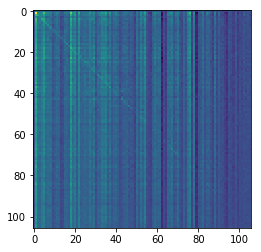

In [298]:
plt.imshow(q_matrix)

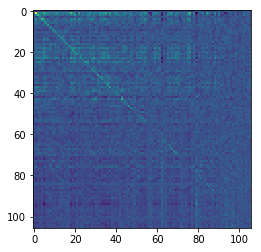

In [300]:
q_matrix_sum=np.sum(q_matrix,axis=0)
q_matrix_n=q_matrix/np.tile(q_matrix_sum,[skill_num-1, 1])
plt.imshow(q_matrix_n)

## Spectral Clustering

In [310]:
spectral = cluster.SpectralClustering(n_clusters=32,affinity='precomputed',eigen_solver='arpack')
dkt_clusters=spectral.fit_predict(q_matrix_n)

//anaconda/envs/pythonEnv/lib/python3.5/site-packages/sklearn/utils/validation.py:640: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


In [302]:
d2={value:key for key, value in skill_dict.items()}
skill_list_dkt=list(range(106))
for key, value in d2.items():
    skill_list_dkt[int(key)-1]=value
    
skill_list_dkt=np.array(skill_list_dkt)

In [313]:
skill_list_dkt[dkt_clusters==0]

array(['Exponents', 'Pattern Finding ', 'Algebraic Simplification'],
      dtype='<U70')

In [312]:
dkt_clusters

array([13,  4, 29, 16,  5,  6, 24, 15,  8, 20, 20,  4, 13, 13,  2, 20, 19,
        4, 10, 25, 16, 28, 18,  7, 28,  3, 13,  2,  5, 10,  8,  3, 11, 12,
       16, 16, 18, 22,  4,  5, 11,  3, 23, 23, 16, 10, 26,  9, 13,  9,  4,
        3, 16,  0,  0, 30,  0, 14, 13,  1, 28,  5, 17,  2, 17, 29, 31,  6,
       17, 16, 20, 15,  1, 27, 12, 11,  4,  8, 22, 13, 22,  4, 25, 28, 13,
       21, 27, 26, 18,  2, 11, 15,  2, 13, 13, 20, 13, 15, 28,  2, 28, 13,
        2,  1, 13, 13], dtype=int32)

In [288]:
skill_dict

{'Absolute Value': 53,
 'Addition Whole Numbers': 36,
 'Addition and Subtraction Fractions': 70,
 'Addition and Subtraction Integers': 67,
 'Addition and Subtraction Positive Decimals': 68,
 'Algebraic Simplification': 57,
 'Algebraic Solving': 58,
 'Angles - Obtuse, Acute, and Right': 88,
 'Angles on Parallel Lines Cut by a Transversal': 20,
 'Area Circle': 25,
 'Area Irregular Figure': 74,
 'Area Parallelogram': 75,
 'Area Rectangle': 76,
 'Area Trapezoid': 77,
 'Area Triangle': 78,
 'Box and Whisker': 1,
 'Calculations with Similar Figures': 28,
 'Choose an Equation from Given Information': 59,
 'Circle Graph': 2,
 'Circumference ': 26,
 'Complementary and Supplementary Angles': 19,
 'Computation with Real Numbers': 90,
 'Congruence': 18,
 'Conversion of Fraction Decimals Percents': 29,
 'Counting Methods': 13,
 'D.4.8-understanding-concept-of-probabilities': 56,
 'Distributive Property': 96,
 'Divisibility Rules': 51,
 'Division Fractions': 37,
 'Effect of Changing Dimensions of a 

In [289]:
d2

{1: 'Box and Whisker',
 2: 'Circle Graph',
 3: 'Histogram as Table or Graph',
 4: 'Number Line',
 5: 'Scatter Plot',
 6: 'Stem and Leaf Plot',
 7: 'Table',
 8: 'Venn Diagram',
 9: 'Mean',
 10: 'Median',
 11: 'Mode',
 12: 'Range',
 13: 'Counting Methods',
 14: 'Probability of Two Distinct Events',
 15: 'Probability of a Single Event',
 16: 'Interior Angles Figures with More than 3 Sides',
 17: 'Interior Angles Triangle',
 18: 'Congruence',
 19: 'Complementary and Supplementary Angles',
 20: 'Angles on Parallel Lines Cut by a Transversal',
 21: 'Pythagorean Theorem',
 22: 'Nets of 3D Figures',
 23: 'Unit Conversion Within a System',
 24: 'Effect of Changing Dimensions of a Shape Prportionally',
 25: 'Area Circle',
 26: 'Circumference ',
 27: 'Perimeter of a Polygon',
 28: 'Calculations with Similar Figures',
 29: 'Conversion of Fraction Decimals Percents',
 30: 'Equivalent Fractions',
 31: 'Ordering Positive Decimals',
 32: 'Ordering Fractions',
 33: 'Ordering Integers',
 34: 'Ordering R

In [290]:
skill_list_dkt

array(['Box and Whisker', 'Circle Graph', 'Histogram as Table or Graph',
       'Number Line', 'Scatter Plot', 'Stem and Leaf Plot', 'Table',
       'Venn Diagram', 'Mean', 'Median', 'Mode', 'Range',
       'Counting Methods', 'Probability of Two Distinct Events',
       'Probability of a Single Event',
       'Interior Angles Figures with More than 3 Sides',
       'Interior Angles Triangle', 'Congruence',
       'Complementary and Supplementary Angles',
       'Angles on Parallel Lines Cut by a Transversal',
       'Pythagorean Theorem', 'Nets of 3D Figures',
       'Unit Conversion Within a System',
       'Effect of Changing Dimensions of a Shape Prportionally',
       'Area Circle', 'Circumference ', 'Perimeter of a Polygon',
       'Calculations with Similar Figures',
       'Conversion of Fraction Decimals Percents', 'Equivalent Fractions',
       'Ordering Positive Decimals', 'Ordering Fractions',
       'Ordering Integers', 'Ordering Real Numbers', 'Rounding',
       'Addition